In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
from glob import glob
import os, sys
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from dataset import *
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

In [3]:
ESIZE = 64
EPS = 30
BSIZE = 64
HSIZE = 256
LAG = 12
SROUTE = SAMPLE_ROUTES[0]
SIND = 30
LR = 0.001
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = SingleStop(SROUTE, SIND, 'train', BSIZE, lag=LAG).generator()
evalset = SingleStop(SROUTE, SIND, 'test', BSIZE, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.22s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.25s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
kernels = None
upops = None

In [6]:
criterion = nn.MSELoss().to(device)
kopt, uopt, sch = None, None, None

In [7]:
from models.Kernel import *

def zip_op(t1, t2, op):
    ls = [(t1, t2)]
    while len(ls):
        n1, n2 = ls[0]
        ls = ls[1:]
        op(n1, n2)
        for c1, c2 in zip(n1['ns'], n2.ns):
            ls.append((c1, c2))

def message(kernels, graph_t):
    zip_op(kernels, graph_t, op=lambda kern, node: kern['op'](node))
    
def update(kernels, graph_t):
    zip_op(upops, graph_t, op=lambda up, node: up['op'](node))
    
def gather_predictions(_node, node):
    # end nodes do not hold convolved results, so they are ignored
    ls = [(_node._v, node.v)] if len(node.ns) else []
    for _nb, nb in zip(_node.ns, node.ns):
        ls += gather_predictions(_nb, nb)
    return ls

losses = []
for ei in range(EPS):
#     for bi in range(0, len(dset) - BSIZE, BSIZE):
#         batch = np.array([dset[bi+jj] for jj in range(BSIZE)])
#         # batch x time x seq
#         batch = torch.Tensor(batch)
    for bi, batch in enumerate(dset):
#         assert batch.size()[0] == BSIZE
#         assert torch.any (batch != batch)
        # batch x time x seq
        batch = routeToGraph(
            batch, 
            zero=lambda: torch.zeros(BSIZE, HSIZE), 
            device=device)

        states = batch[0] # will be used to hold iterated values
        if kernels is None:
            (kernels,), params = inst_tree(
                lambda node: Kernel(insize=1 + len(node.ns), hsize=HSIZE).to(device), 
                [states], device=device)
            kopt = optim.SGD(params, lr=LR)
            print('Params: %d' % len(params))
            (upops,), params = inst_tree(
                lambda _: Update(hsize=HSIZE).to(device), 
                [states], device=device)
            uopt = optim.SGD(params, lr=LR)

        # initial iteration
        _ = message(kernels, states)
        _ = update(upops, states)

        def fit(_ys, ys, retain=True):
            kopt.zero_grad()
            uopt.zero_grad()
            loss = criterion(ys, _ys)

            loss.backward(retain_graph=retain)
            kopt.step()
            uopt.step()
            return loss

        for ti, graph_t in enumerate(batch[1:]):
            # compute loss
            _ys, ys = zip(*gather_predictions(graph_t, states))
            _ys, ys = torch.cat(_ys, dim=1), torch.cat(ys, dim=1)

            loss = fit(_ys, ys, True)

            # iterate
            _ = message(kernels, states)
            _ = update(upops, states)

            sys.stdout.write('[E%d:%d - B%d:%d - T%d:%d] L%.2f    \r' % (
                ei + 1, EPS,
                bi, len(dset), ti+2, len(batch),
                loss.item()))
            losses.append(loss.item())
        fit(_ys, ys, False) # don't forget to fit the last iteration

        sys.stdout.flush()

Params: 114


Process Process-19:
Process Process-21:
Process Process-22:
Process Process-24:
Process Process-23:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-20:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(ti

KeyboardInterrupt: 

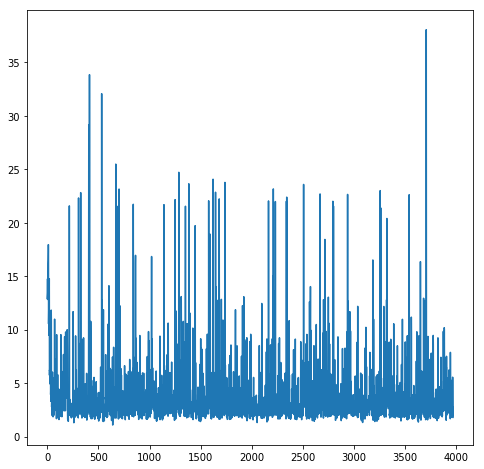

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show(); plt.close()

In [9]:
_ys, ys = zip(*gather_predictions(graph_t, states))
_ys, ys = torch.cat(_ys, dim=1), torch.cat(ys, dim=1)

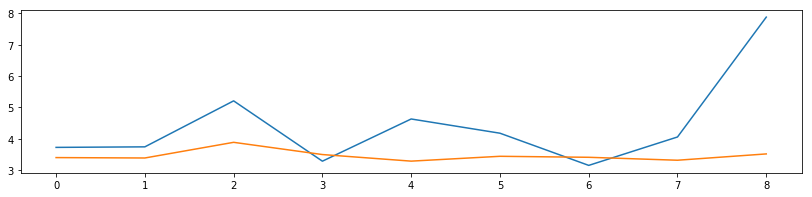

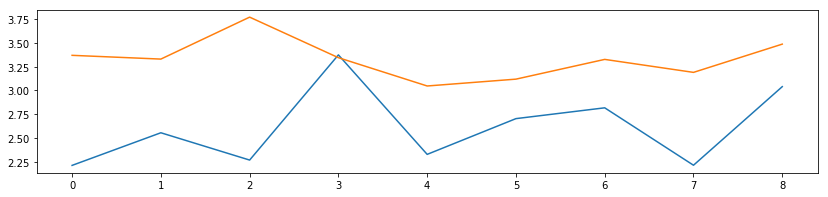

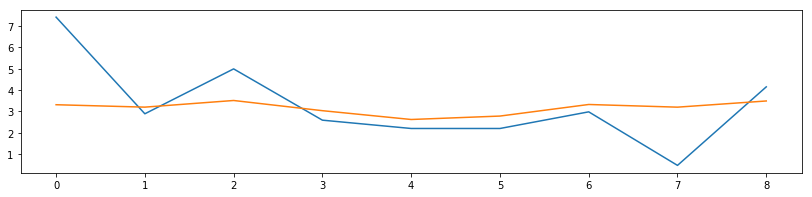

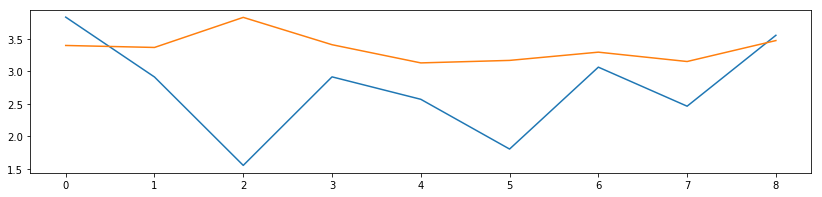

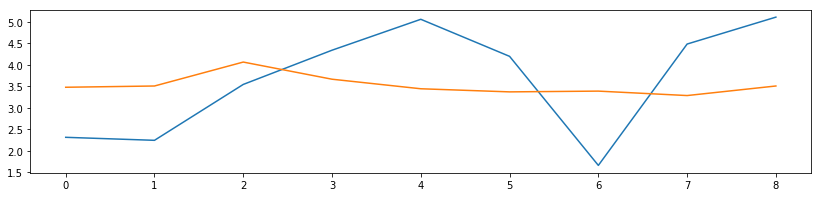

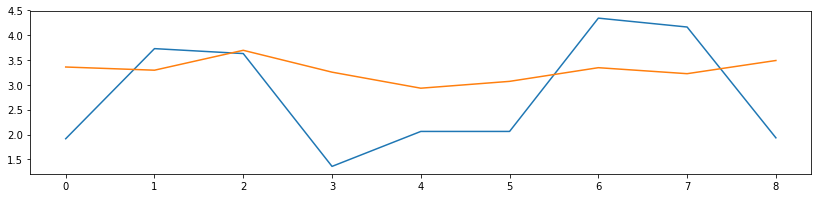

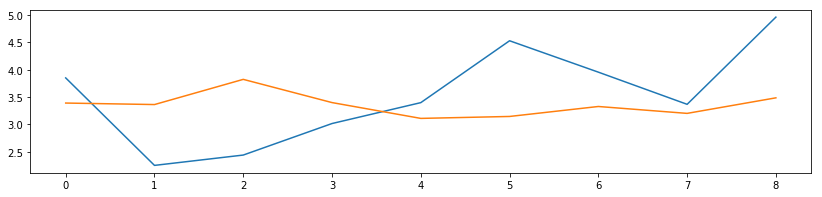

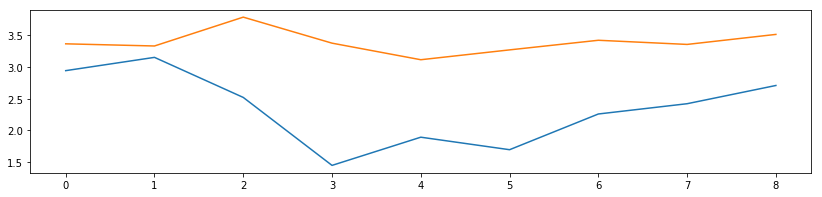

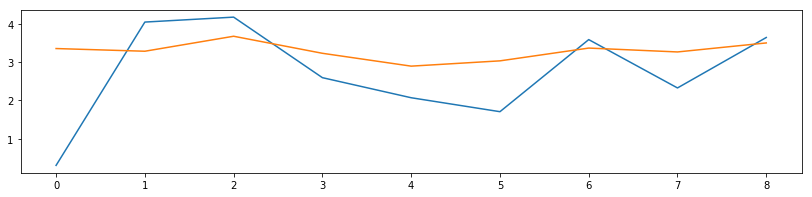

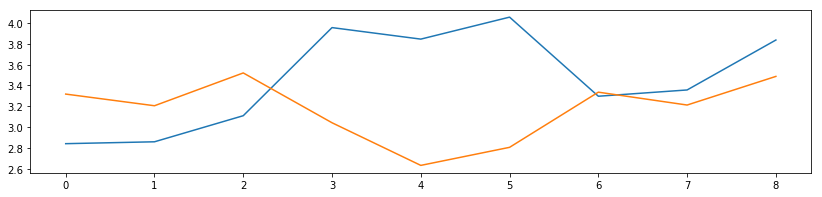

In [10]:
for ii in range(10):
    plt.figure(figsize=(14, 3))
    plt.plot(tonpy(_ys)[ii])
    plt.plot(tonpy(ys)[ii])
    plt.show(); plt.close()